In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import poisson
import h5py
from pathlib import Path
from ligo.skymap.io.fits import read_sky_map
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
#from mdc_analytics.crossmatch.gracedb import _process_skymap_offline, parallelize, CROSSMATCH_KEYS
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
import ligo.skymap.plot
from functools import partial
from ligo.gracedb.rest import GraceDb
from io import BytesIO
from igwn_ligolw import lsctables
from igwn_ligolw import utils as ligolw_utils
from ligo.skymap.io import events
from gwpy.time import tconvert
from bilby.core.result import Result
from tqdm.auto import tqdm
import ligo.skymap.plot

SECONDS_PER_YEAR = 365.25 * 24 * 3600
ORIGINAL_START = 1398297600
ORIGINAL_END = 1398902400
LLPIC_DURATION = 7 * 86400
LLPIC_CYCLE_1_OFFSET = 31678218
SUPEREVENT_TIMES = np.array([1398380098.077, 1398504935.380, 1398569752.925])

In [3]:
data = pd.read_hdf("/home/ethan.marx/projects/mdc_analytics/output/aframe-playground-llpic/all_pipelines/events.hdf5")

## Skymap Plots

### Searched Area

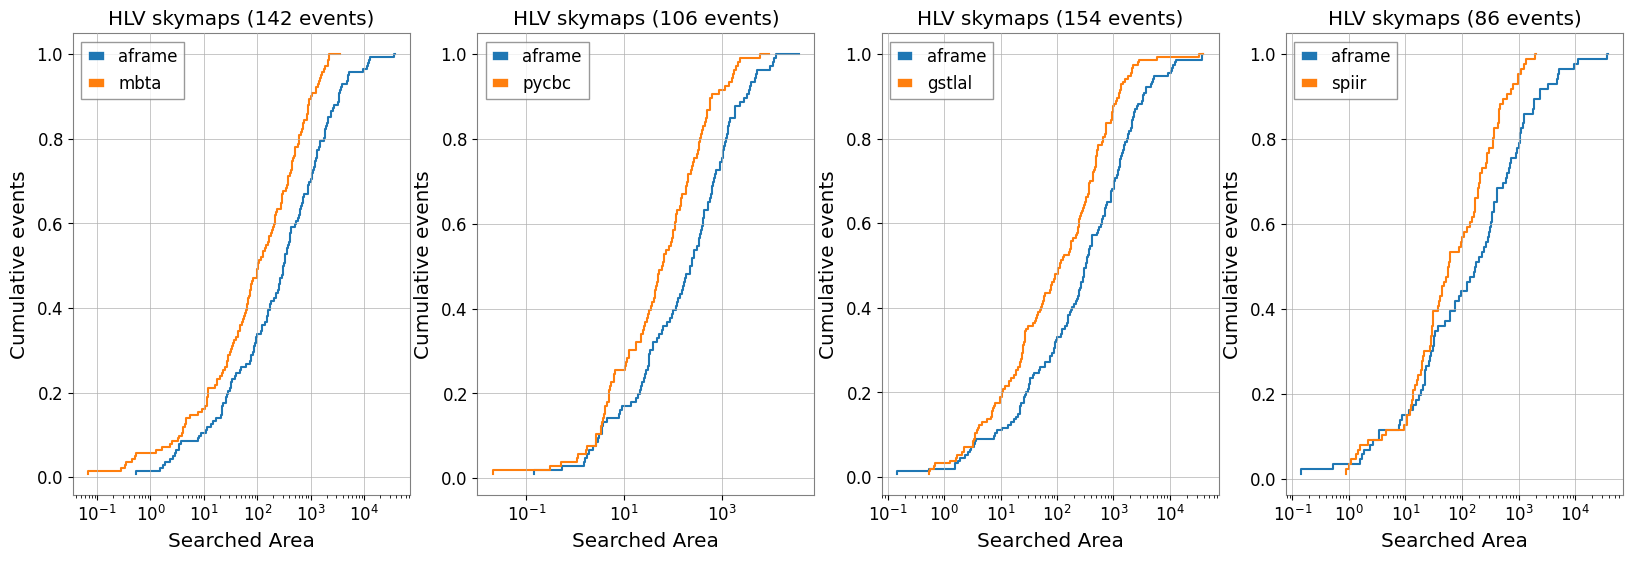

In [4]:
pipelines = ["mbta", "pycbc", "gstlal", "spiir"] 
ifo_configs = ["HLV"]
fig, ax = plt.subplots(len(ifo_configs), len(pipelines), figsize = (20,  6 * len(ifo_configs)))

while ax.ndim < 2:
    ax = ax[None]

for row, ifo_config in zip(ax, ifo_configs):
    for ax, pipeline in zip(row, pipelines):

        pipeline_key = f"{pipeline}_searched_area_{ifo_config}"
        mask = np.ones(len(data), dtype=bool)
        try: 
            mask = getattr(data, pipeline_key).notnull()
        except AttributeError:
            ax.set_axis_off()
            continue
        
        mask &= getattr(data, f"aframe_searched_area_{ifo_config}").notnull()
        counts = np.arange(1, sum(mask) + 1) / sum(mask) 

        ax.set_title(f"{ifo_config} skymaps ({sum(mask)} events)")
        ax.step(np.sort(getattr(data[mask], f"aframe_searched_area_{ifo_config}")), counts, label="aframe")
        ax.step(np.sort(getattr(data[mask], pipeline_key)), counts, label=pipeline)
        ax.set_xscale("log")
        ax.set_xlabel("Searched Area")
        ax.set_ylabel("Cumulative events")
        ax.legend()

### Searched Volume

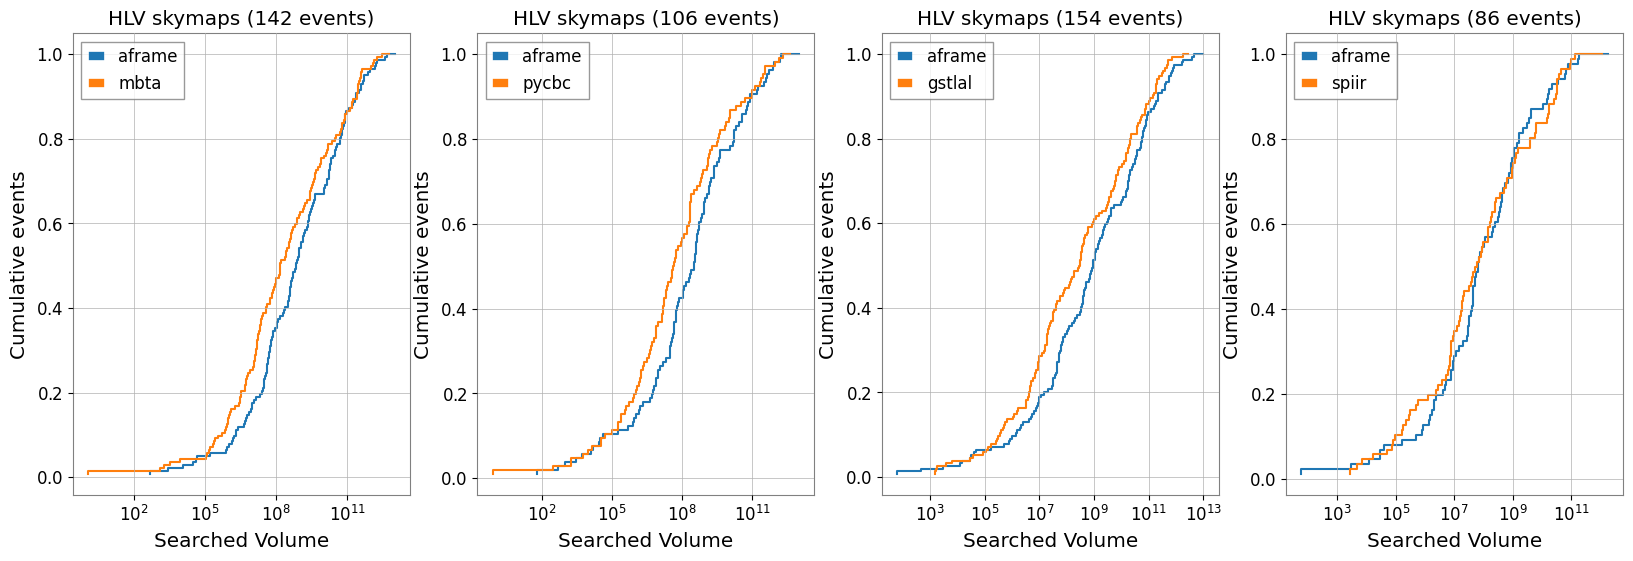

<Figure size 700x700 with 0 Axes>

In [5]:
pipelines = ["mbta", "pycbc", "gstlal", "spiir"] 
ifo_configs = ["HLV"]
fig, ax = plt.subplots(len(ifo_configs), len(pipelines), figsize = (20,  6 * len(ifo_configs)))

while ax.ndim < 2:
    ax = ax[None]

for row, ifo_config in zip(ax, ifo_configs):
    for ax, pipeline in zip(row, pipelines):

        pipeline_key = f"{pipeline}_searched_vol_{ifo_config}"
        mask = np.ones(len(data), dtype=bool)
        try: 
            mask = getattr(data, pipeline_key).notnull()
        except AttributeError:
            ax.set_axis_off()
            continue
        
        mask &= getattr(data, f"aframe_searched_vol_{ifo_config}").notnull()
        counts = np.arange(1, sum(mask) + 1) / sum(mask) 

        ax.set_title(f"{ifo_config} skymaps ({sum(mask)} events)")
        ax.step(np.sort(getattr(data[mask], f"aframe_searched_vol_{ifo_config}")), counts, label="aframe")
        ax.step(np.sort(getattr(data[mask], pipeline_key)), counts, label=pipeline)
        ax.set_xscale("log")
        ax.set_xlabel("Searched Volume")
        ax.set_ylabel("Cumulative events")
        ax.legend()
ig = plt.figure(figsize=(7, 7))


### Skymap Consistency

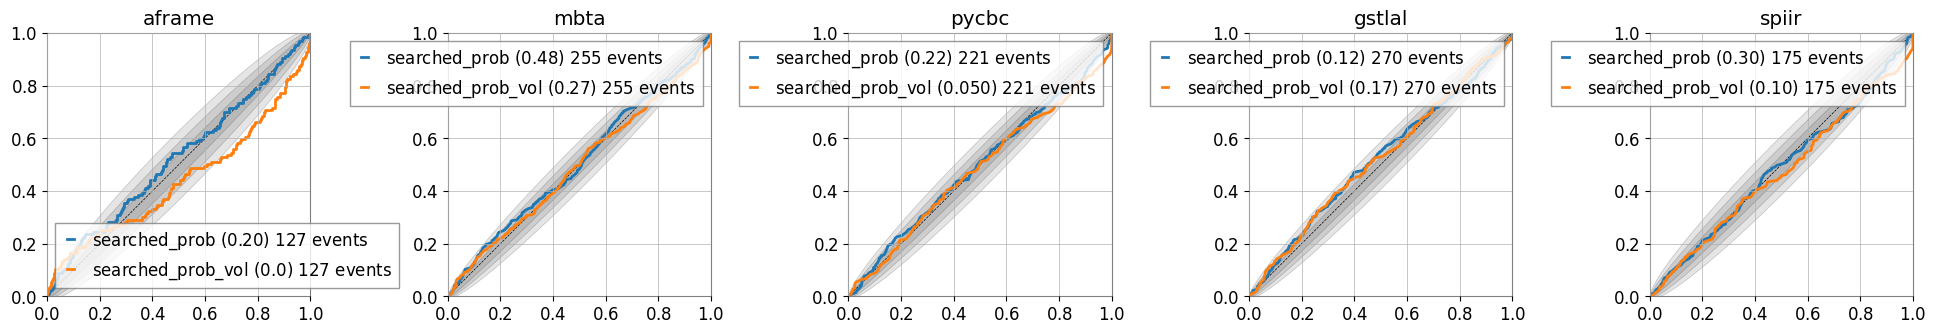

In [6]:
pipelines = ["aframe", "mbta", "pycbc", "gstlal", "spiir"] 
fig = plt.figure(figsize=(20, 10))
for i, pipeline in enumerate(pipelines):
    ax = fig.add_subplot(1, len(pipelines), i + 1, projection="pp_plot")
    for j, attr in enumerate(["searched_prob", "searched_prob_vol"]):
        
        pipeline_key = f"{pipeline}_{attr}_{ifo_config}"
       
        mask = np.ones(len(data), dtype=bool)
        mask &= getattr(data, pipeline_key).notnull()
        mask &= data.snr_net > 10
        number_of_samples = sum(mask) 

        if j == 0:
            alphas = [0.68, 0.95, 0.997]
            for alpha in alphas:
                ax.add_confidence_band(
                    number_of_samples,
                    alpha=alpha,
                    color=(0, 0, 0, 0.1),
                    edgecolor=(0, 0, 0, 0.2),
                    annotate=False,
                )
            ax.add_diagonal()
        
        counts = np.arange(1, number_of_samples + 1) / sum(mask) 
        p = scipy.stats.kstest(data[mask][pipeline_key], "uniform").pvalue
        ax.set_title(pipeline)
        ax.add_series(
            data[mask][pipeline_key], 
            label=attr 
            + r"$~({0:#.2g})$ ".format(round(p, 2))
            + str(number_of_samples)
            + " events",
            linewidth=2,
        )
        ax.legend()
plt.tight_layout()

## Scatter Plots

### Chirp Mass Recovery

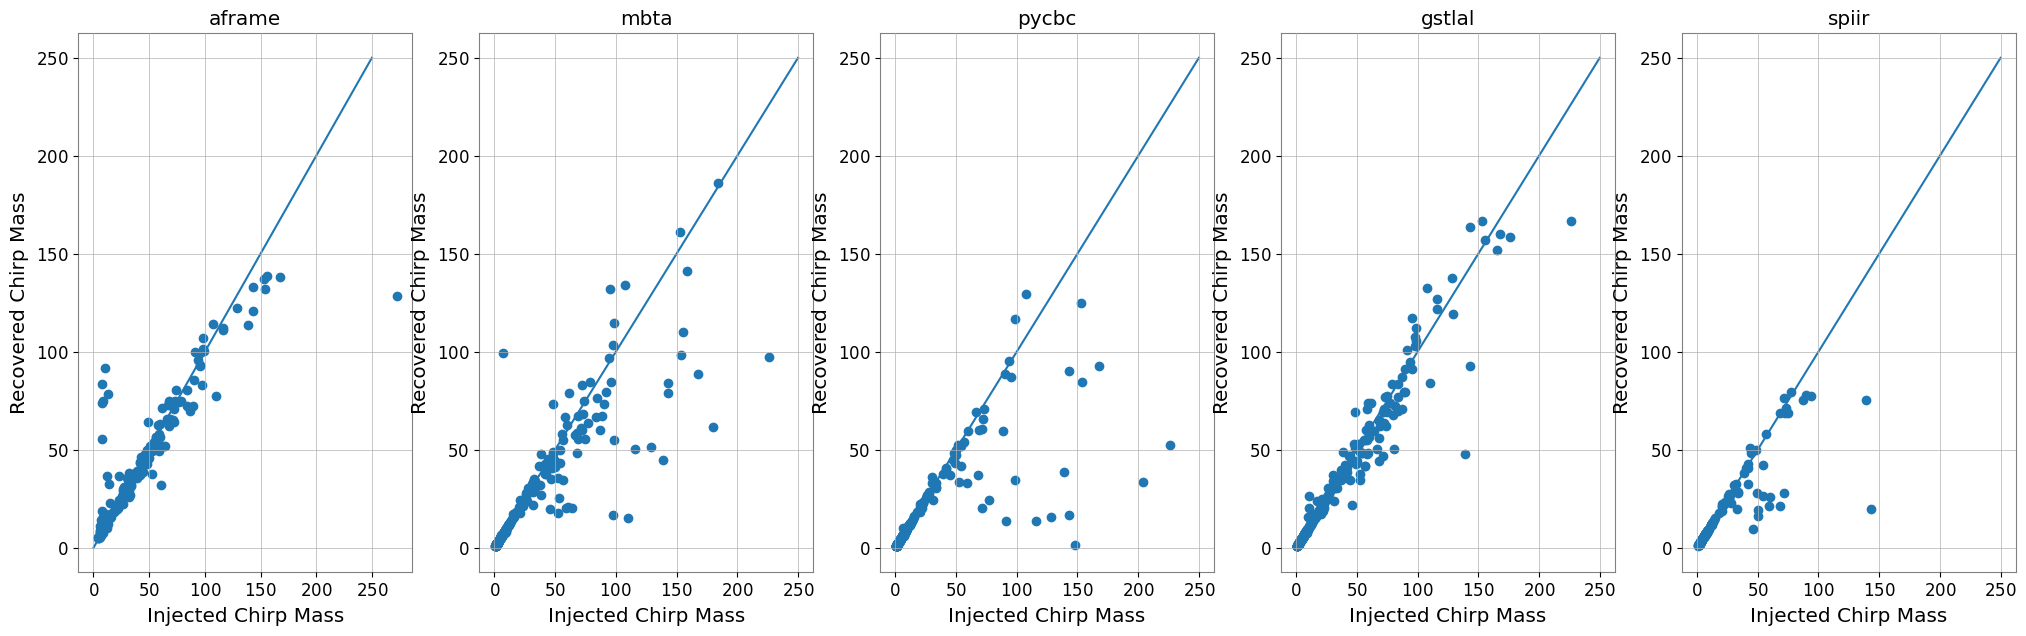

In [7]:
fig, axs = plt.subplots(1, len(pipelines), figsize = (25, 7))
for ax, pipeline in zip(axs, pipelines):
    found = data[f"{pipeline}_graceid"].values != "" 
    found = data[found]
    ax.scatter(found["chirp_mass"], found[f"{pipeline}_chirp_mass"])
    ax.set_xlabel("Injected Chirp Mass")
    ax.set_ylabel("Recovered Chirp Mass")
    ax.plot([0, 250], [0, 250])
    ax.set_title(pipeline)

### Distance Recovery

Text(0.5, 1.0, 'aframe')

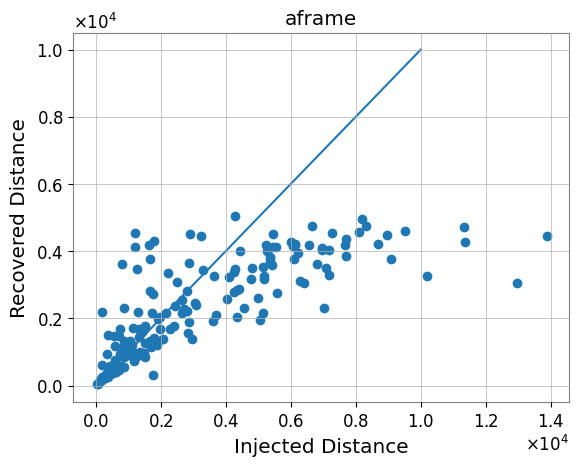

In [8]:
fig = plt.figure()

pipeline = "aframe"
found = data[f"{pipeline}_graceid"].values != "" 
found = data[found]
plt.scatter(found["luminosity_distance"], found[f"{pipeline}_luminosity_distance"])
plt.xlabel("Injected Distance")
plt.ylabel("Recovered Distance")
plt.plot([0, 1e4], [0, 1e4])
plt.title(pipeline)

# Upset Plots

In [9]:
from upsetplot import UpSet, from_indicators

/home/william.benoit/ML4GW/mdc-analytics/.venv/lib64/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/william.benoit/ML4GW/mdc-analytics/.venv/lib64/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

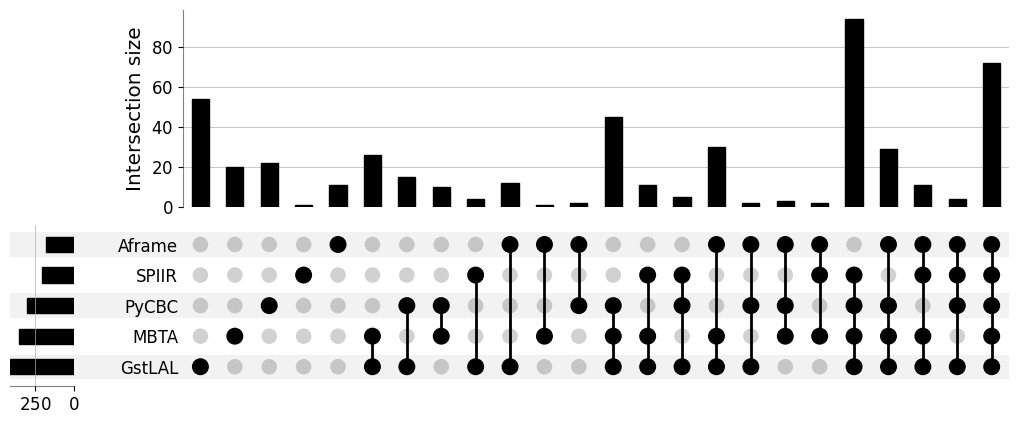

In [10]:
pipelines = ["mbta", "pycbc", "gstlal", "spiir", "aframe"]

label_map = {
    "pycbc": "PyCBC",
    "gstlal": "GstLAL",
    "mbta": "MBTA",
    "spiir": "SPIIR",
    "aframe": "Aframe"
}
found_masks = {
    p: (data[f"{p}_graceid"] != "") & data[f"{p}_graceid"].notna()
    for p in pipelines
}
found_indices = {p: data.index[mask] for p, mask in found_masks.items()}
all_ids = pd.Index(sorted(set.union(*(set(idxs) for idxs in found_indices.values()))))
df_upset = pd.DataFrame({'events': all_ids})
for p in pipelines:
    df_upset[label_map[p]] = df_upset['events'].isin(found_indices[p])

df_upset.set_index('events', inplace=True)
upset_data = from_indicators(df_upset.columns, df_upset)
UpSet(upset_data, subset_size='count').plot()
plt.show()

# FAR Consistency

In [4]:
burst_and_background = pd.read_hdf("/home/ethan.marx/projects/mdc_analytics/output/aframe-playground-llpic/all_pipelines/aframe_noise.hdf5")

In [6]:
event_times = np.array(burst_and_background["gpstime"])
offset = LLPIC_CYCLE_1_OFFSET
while (event_times.max() - offset) > ORIGINAL_END:
    offset += LLPIC_DURATION

burst_times = []
with h5py.File("data/o4-llpic-burst-injections.hdf5", "r") as f:
    for key in f.keys():
        for i in f[key]["PARAMETERS"]:
            burst_times.append(i[0])
burst_times = np.array(burst_times) + offset
min_diff = np.min(np.abs(event_times[:, None] - burst_times[None, :]), axis=1)
mask_burst = min_diff < 1

superevent_times = SUPEREVENT_TIMES + offset
min_diff = np.min(np.abs(event_times[:, None] - superevent_times[None, :]), axis=1)
mask_superevent = min_diff < 1
mask = mask_burst | mask_superevent

non_injection_events = burst_and_background[~mask_burst]
noise_events = burst_and_background[~mask]

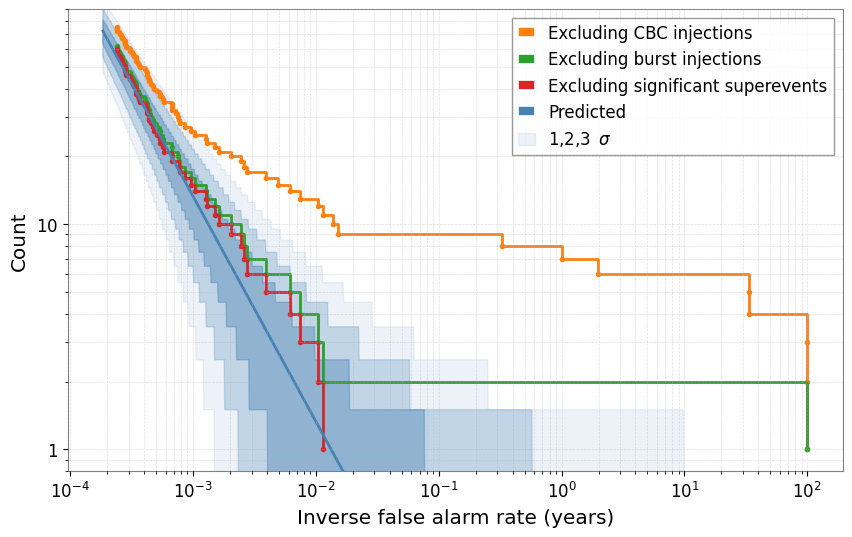

In [7]:
tb = np.sum(np.loadtxt("data/o4-llpic-segments.txt", usecols=3))

plt.figure(figsize=(10, 6))

dfs = [burst_and_background, non_injection_events, noise_events]
labels = ["Excluding CBC injections", "Excluding burst injections", "Excluding significant superevents"]

for i, (df, label) in enumerate(zip(dfs, labels)):
    ifars = np.sort(1 / df["far"]) / SECONDS_PER_YEAR
    counts = np.arange(1, len(ifars) + 1)[::-1]

    y_vals = np.logspace(np.log10(max(counts) * 1.2), -3, 1000)
    x_pred = tb / y_vals / SECONDS_PER_YEAR

    plt.step(
        ifars,
        counts,
        where="post",
        lw=2,
        marker="o",
        ms=3,
        color=f"C{i + 1}",
        label=label,
    )

sigma_alphas = (0.4, 0.25, 0.1)
sig_bands = []
for fap in (0.682689, 0.954499, 0.997300):
    band = np.array(poisson.interval(fap, y_vals))
    band[0] = np.maximum(band[0] - 0.5, 0)
    band[1] += 0.5
    sig_bands.append(band)

plt.plot(x_pred, y_vals, color="steelblue", lw=2, label="Predicted")

labels = [r"1,2,3 $\,\sigma$"] + [None, None]
for band, alpha, lab in zip(sig_bands[::-1], sigma_alphas[::-1], labels):
    plt.fill_between(
        x_pred, band[0], band[1], color="steelblue", alpha=alpha, label=lab
    )
plt.xscale("log")
plt.yscale("log")
# plt.xlim(ifars.min() * 0.9, ifars.max() * 10.2)
plt.ylim(0.8, counts.max() * 1.5)
plt.xlabel("Inverse false alarm rate (years)")
plt.ylabel("Count")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(frameon=True)
plt.show()

# Background Event Plots

In [8]:
num_noise_events = 2

idx = np.argsort(noise_events["far"])[:num_noise_events]
gpstimes = noise_events["gpstime"].iloc[idx]

url_start = "https://ldas-jobs.ligo.caltech.edu/~aframe/o4_llpic_playground/events/"
urls = [f"{url_start}event_{int(gpstime)}/event.html" for gpstime in gpstimes]
print("\n".join(urls))

https://ldas-jobs.ligo.caltech.edu/~aframe/o4_llpic_playground/events/event_1436425784/event.html
https://ldas-jobs.ligo.caltech.edu/~aframe/o4_llpic_playground/events/event_1436117815/event.html


# Superevent Plots

In [41]:
superevents = burst_and_background[mask_superevent]

idx = np.argsort(superevents["far"])
gpstimes = superevents["gpstime"].iloc[idx]

url_start = "https://ldas-jobs.ligo.caltech.edu/~aframe/o4_llpic_playground/events/"
urls = [f"{url_start}event_{int(gpstime)}/event.html" for gpstime in gpstimes]
print("\n".join(urls))

https://ldas-jobs.ligo.caltech.edu/~aframe/o4_llpic_playground/events/event_1436295970/event.html
https://ldas-jobs.ligo.caltech.edu/~aframe/o4_llpic_playground/events/event_1436231153/event.html


## Bilby posterior for S240501an

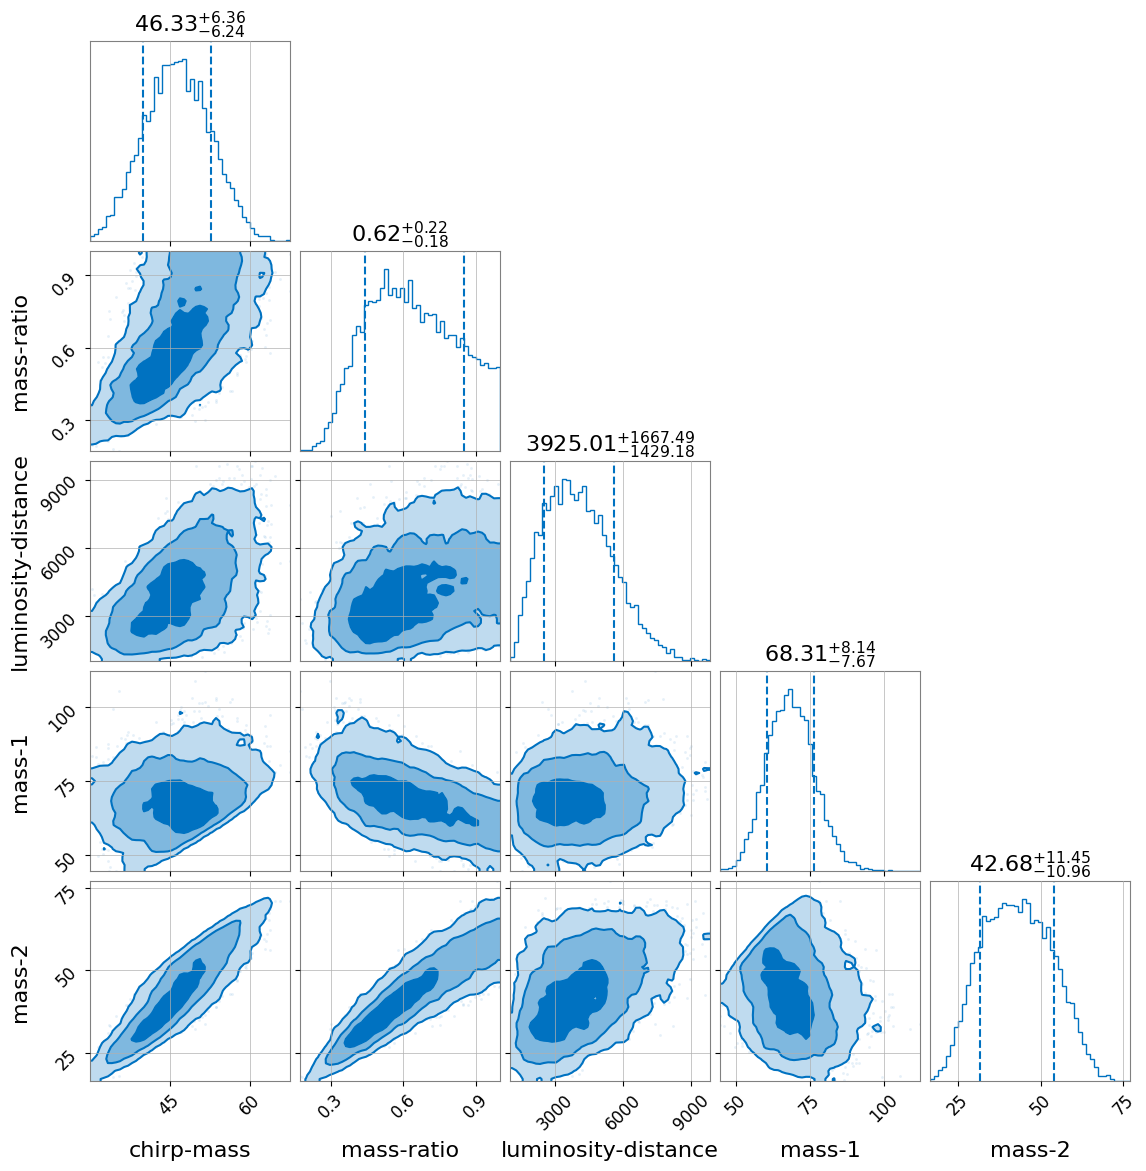

In [40]:
posterior = pd.read_hdf("data/Bilby.posterior_samples.hdf5", key="posterior_samples")
params = ["chirp_mass", "mass_ratio", "luminosity_distance", "mass_1", "mass_2"]

from astropy.cosmology import Planck18 as cosmo, z_at_value
from astropy import units as u
redshift= z_at_value(
    cosmo.luminosity_distance, np.array(posterior["luminosity_distance"]) * u.Mpc
).value
posterior["mass_1"] = posterior["mass_1_source"] * (1 + redshift)
posterior["mass_2"] = posterior["mass_2_source"] * (1 + redshift)
posterior["mass_ratio"] = posterior["mass_2"] / posterior["mass_1"]
posterior["chirp_mass"] = (
    posterior["mass_1"] * posterior["mass_2"]
) ** (3 / 5) / (posterior["mass_1"] + posterior["mass_2"]) ** (1 / 5)
posterior = posterior[params]

result = Result(posterior=posterior, search_parameter_keys=params)
result.plot_corner()